In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# **Installing Necessary Libraries**

Pandas for Data Loading and Manipulation

Numpy for MAthematical operation

Seaborn for Visualization

Matplotlib for Visualiztion

NLTK for NLP Operation

Spacy for NLP

In [101]:
!pip install pandas numpy scikit-learn nltk spacy

Downloading Spacy Small Model

In [102]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# 1. **Importing Libraries**

In [103]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt




In [104]:
# Download the pre-trained NLTK stopwords and tokenizer models
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **2. Data Loading**

In [105]:
# Load the IMDB dataset
data = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

# Display the first few rows of the dataset
print(data.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [107]:
data.shape

(50000, 2)

There are 50k rows and 2 columns

In [108]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

There are no null values

In [109]:
data.describe(include='all')

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


There are  49582 unique reviews and 2 unique sentiment namely Positive Negative

**Basic Data Exploration**

In [110]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [111]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

From this column we can say that our taget column is balanced

Data Visualization

Text(0.5, 1.0, 'Sentiment Distribution')

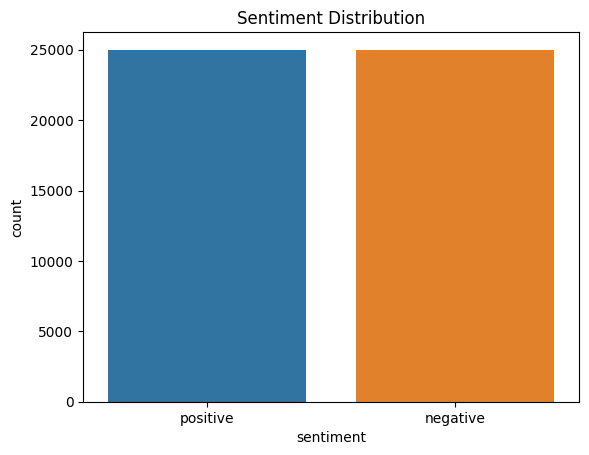

In [112]:
sns.countplot(x='sentiment',data=data)
plt.title('Sentiment Distribution')

In [113]:
for i in range(10):
    print(data['review'].iloc[i],'\n')
    print('sentiment:',data['sentiment'].iloc[i],'\n\n')
    
    

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

**Data Cleansing**

In [114]:
print("duplicated   values",data.duplicated().sum())

duplicated   values 418


In [115]:
data.drop_duplicates(inplace=True)

**Model Building**

In [116]:
# Convert the sentiment labels to binary format
data['sentiment']= data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)



In [117]:
data['sentiment'].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

In [118]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import spacy

# Initialize necessary tools
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\@w+|#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Cleaned Text
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words]

    # Join words back into a single string
    processed_text = ' '.join(words)

    # Remove extra whitespaces
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text


# Apply preprocessing to the review column
data['processed_review'] = data['review'].apply(preprocess_text)

# Display the preprocessed data



In [119]:
print(data.head())

                                              review  sentiment  \
0  One of the other reviewers has mentioned that ...          1   
1  A wonderful little production. <br /><br />The...          1   
2  I thought this was a wonderful way to spend ti...          1   
3  Basically there's a family where a little boy ...          0   
4  Petter Mattei's "Love in the Time of Money" is...          1   

                                    processed_review  
0  one review mention watch oz episod youll hook ...  
1  wonder littl product film techniqu unassum old...  
2  thought wonder way spend time hot summer weeke...  
3  basic there famili littl boy jake think there ...  
4  petter mattei love time money visual stun film...  


In [121]:
# Split the data into training (80%) and testing (20%) sets stratify for sentiment so that in train we have equal number of both clasess 
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_review'], data['sentiment'], test_size=0.2, random_state=42,stratify=data['sentiment']
)

# Display the number of samples in each set
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")


Training set: 39665 samples
Testing set: 9917 samples


In [122]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [123]:

# Define the Multinomial Naive Bayes model
mnb = MultinomialNB()

# Define the parameter grid for alpha (smoothing parameter)
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Initialize GridSearchCV to search for the best parameter
grid_search_mnb = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_mnb.fit(X_train_tfidf, y_train)

# Get the best model and parameters
best_mnb = grid_search_mnb.best_estimator_
print(f"Best Parameters for MultinomialNB: {grid_search_mnb.best_params_}")

# Make predictions on the test set using the best model
y_pred = best_mnb.predict(X_test_tfidf)



Best Parameters for MultinomialNB: {'alpha': 5.0}


In [127]:
from sklearn.metrics import precision_score

In [129]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the classification report
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8486
Precision: 0.8505
Recall: 0.8473
F1-score: 0.8489

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4940
           1       0.85      0.85      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



# Model Performance Report

## Overview
The above report presents the performance metrics for  binary classification model. The evaluation metrics which are included is accuracy, precision, recall, and F1-score, which provide insight into our model's effectiveness.

## Key Metrics
 **Accuracy**: 0.8486
 **Precision**: 0.8505
 **Recall**: 0.8473
 **F1-score**: 0.8489

## Classification Report
| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|--------|
|   0   |   0.850   |  0.850 |   0.850  |   4940 |
|   1   |   0.850   |  0.850 |   0.850  |   4977 |

### Overall Metrics
  **Accuracy**: 0.85 (85%)
  **Macro Average**:
   Precision: 0.85
   Recall: 0.85
   F1-score: 0.85
- **Weighted Average**:
   Precision: 0.85
   Recall: 0.85
   F1-score: 0.85

## Interpretation
 **Accuracy** of 0.8486 indicates that the model correctly predicts approximately 85% of the instances.
 **Precision** of 0.8505 suggests that when the model predicts the positive class (1), it is correct about 85% of the time.
  **Recall** of 0.8473 indicates that the model identifies about 85% of the actual positive instances.
The **F1-score** of 0.8489 provides a balance between precision and recall, showing that the model performs well in terms of both metrics.

## Conclusion
The model demonstrates strong performance with consistent metrics across precision, recall, and F1-score, indicating it is reliable for this classification task. 